In [17]:
from itertools import product
from typing import Tuple, Dict, Any, Optional
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    auc,
)
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [19]:
df = pd.read_csv("Customer Churn.csv")

In [21]:
df.columns = df.columns.str.lower().str.replace(r'\s+', '_', regex=True)

In [23]:
# The 'tariff_plan' and 'status' columns are binary, but use 2 and 1 instead of the standard 0 and 1.
# This code replaces all occurrences of 2 with 0 to standardize the binary format.
df[['tariff_plan', 'status']] = df[['tariff_plan', 'status']].replace(2, 0)

In [25]:
# Generate summary statistics
summary_stats = df.describe().transpose()

# Style the table
styled_summary = summary_stats.style.format("{:.2f}")\
    .set_caption("Summary Statistics")

# Display the styled table
styled_summary

,count,mean,std,min,25%,50%,75%,max
call_failure,3150.00,7.63,7.26,0.00,1.00,6.00,12.00,36.00
complains,3150.00,0.08,0.27,0.00,0.00,0.00,0.00,1.00
subscription_length,3150.00,32.54,8.57,3.00,30.00,35.00,38.00,47.00
charge_amount,3150.00,0.94,1.52,0.00,0.00,0.00,1.00,10.00
seconds_of_use,3150.00,4472.46,4197.91,0.00,1391.25,2990.00,6478.25,17090.00
frequency_of_use,3150.00,69.46,57.41,0.00,27.00,54.00,95.00,255.00
frequency_of_sms,3150.00,73.17,112.24,0.00,6.00,21.00,87.00,522.00
distinct_called_numbers,3150.00,23.51,17.22,0.00,10.00,21.00,34.00,97.00
age_group,3150.00,2.83,0.89,1.00,2.00,3.00,3.00,5.00
tariff_plan,3150.00,0.92,0.27,0.00,1.00,1.00,1.00,1.00


In [27]:
# Check for null values
null_counts = df.isnull().sum()

print(null_counts)

call_failure               0
complains                  0
subscription_length        0
charge_amount              0
seconds_of_use             0
frequency_of_use           0
frequency_of_sms           0
distinct_called_numbers    0
age_group                  0
tariff_plan                0
status                     0
age                        0
customer_value             0
churn                      0
dtype: int64


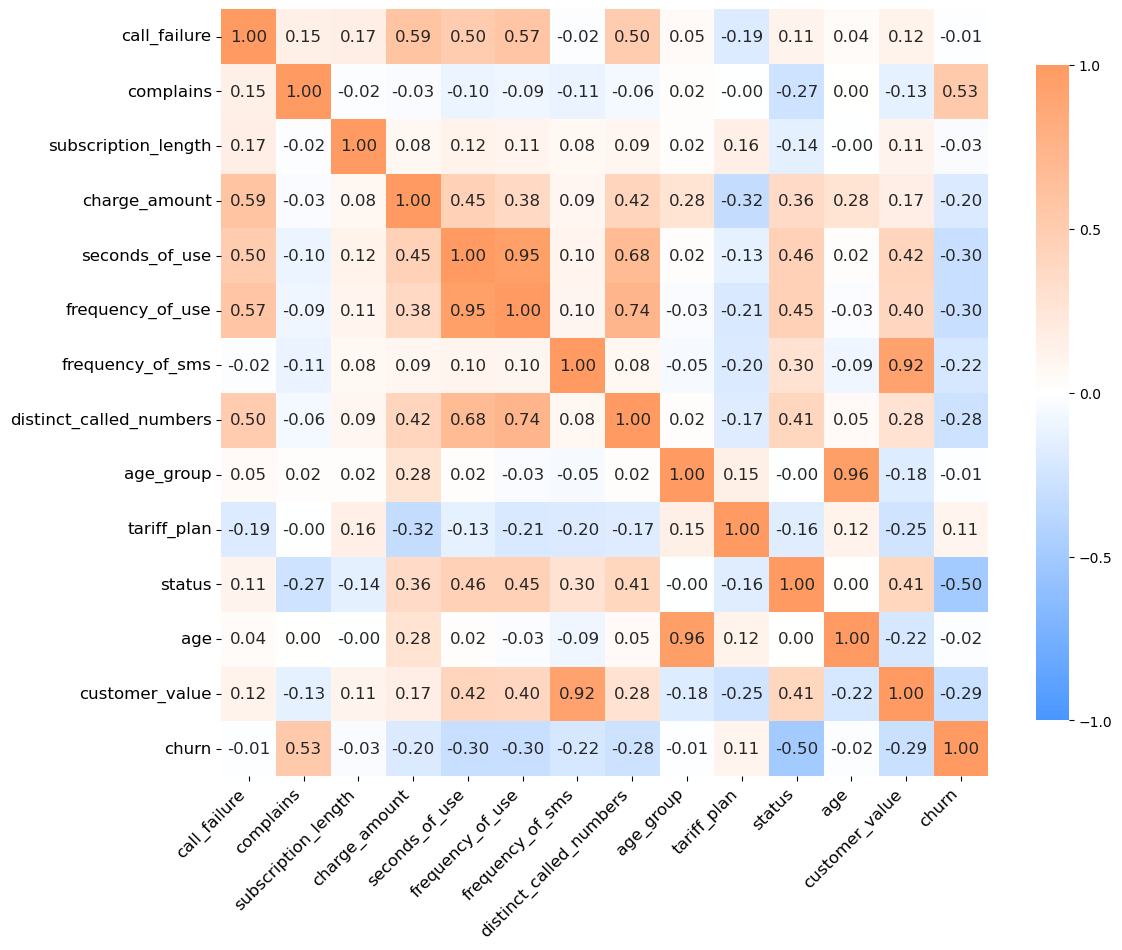

In [29]:
def create_correlation_heatmap(df, figsize=(12, 10)):
    """
    Create a correlation heatmap with colors matching the distribution plots
    """
    corr_table = df.corr()
    
    plt.figure(figsize=figsize, facecolor='white')
    
    # Use the exact same colors as the distribution plots
    colors = ["#4996FF", "#ffffff", "#FF9B62"]  # Blue - White - Orange
    custom_cmap = LinearSegmentedColormap.from_list("custom", colors)
    
    sns.heatmap(
        corr_table,
        annot=True,
        fmt='.2f',
        cmap=custom_cmap,
        center=0,
        vmin=-1,
        vmax=1,
        square=True,
        annot_kws={'size': 12},  # Increased font size for annotations
        cbar_kws={
            'shrink': .8,
            'label': '',
            'ticks': [-1, -0.5, 0, 0.5, 1]
        }
    )
    
    plt.xticks(rotation=45, ha='right', fontsize=12)  # Increased font size for x-axis labels
    plt.yticks(rotation=0, fontsize=12)  # Increased font size for y-axis labels
    
    plt.box(False)
    plt.tight_layout()
    
    return plt.gcf()

fig = create_correlation_heatmap(df)
fig.savefig("correlation_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()


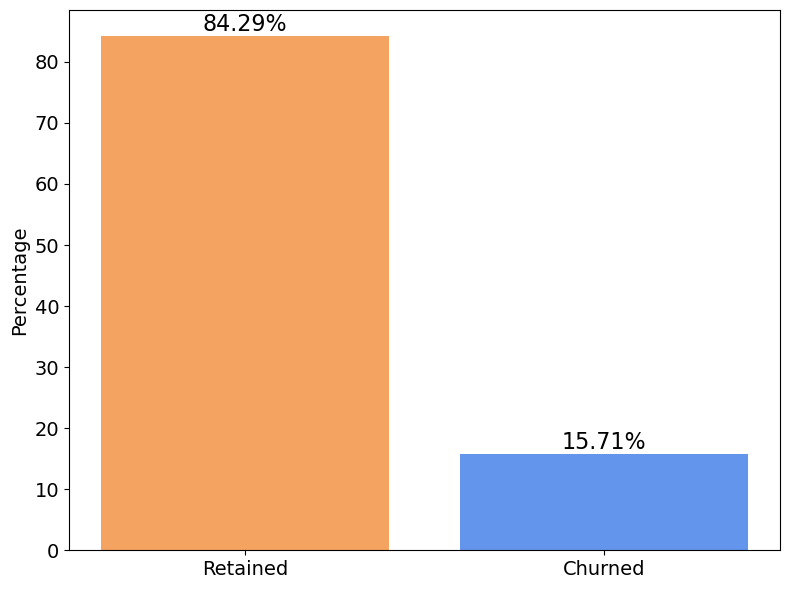

In [39]:
# Calculate the values
churn_counts = df.churn.value_counts()
total = churn_counts.sum()
percentages = (churn_counts / total * 100)

# Create the bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar([0, 1], percentages, color=['sandybrown', 'cornflowerblue'])
plt.ylabel('Percentage', fontsize=14)
plt.yticks(fontsize=14)
plt.xticks([0, 1], ['Retained', 'Churned'], fontsize=14)

# Add percentage labels on top of bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{percentages[i]:.2f}%',
             ha='center', va='bottom', fontsize=16)

plt.tight_layout()
plt.savefig('churn_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()


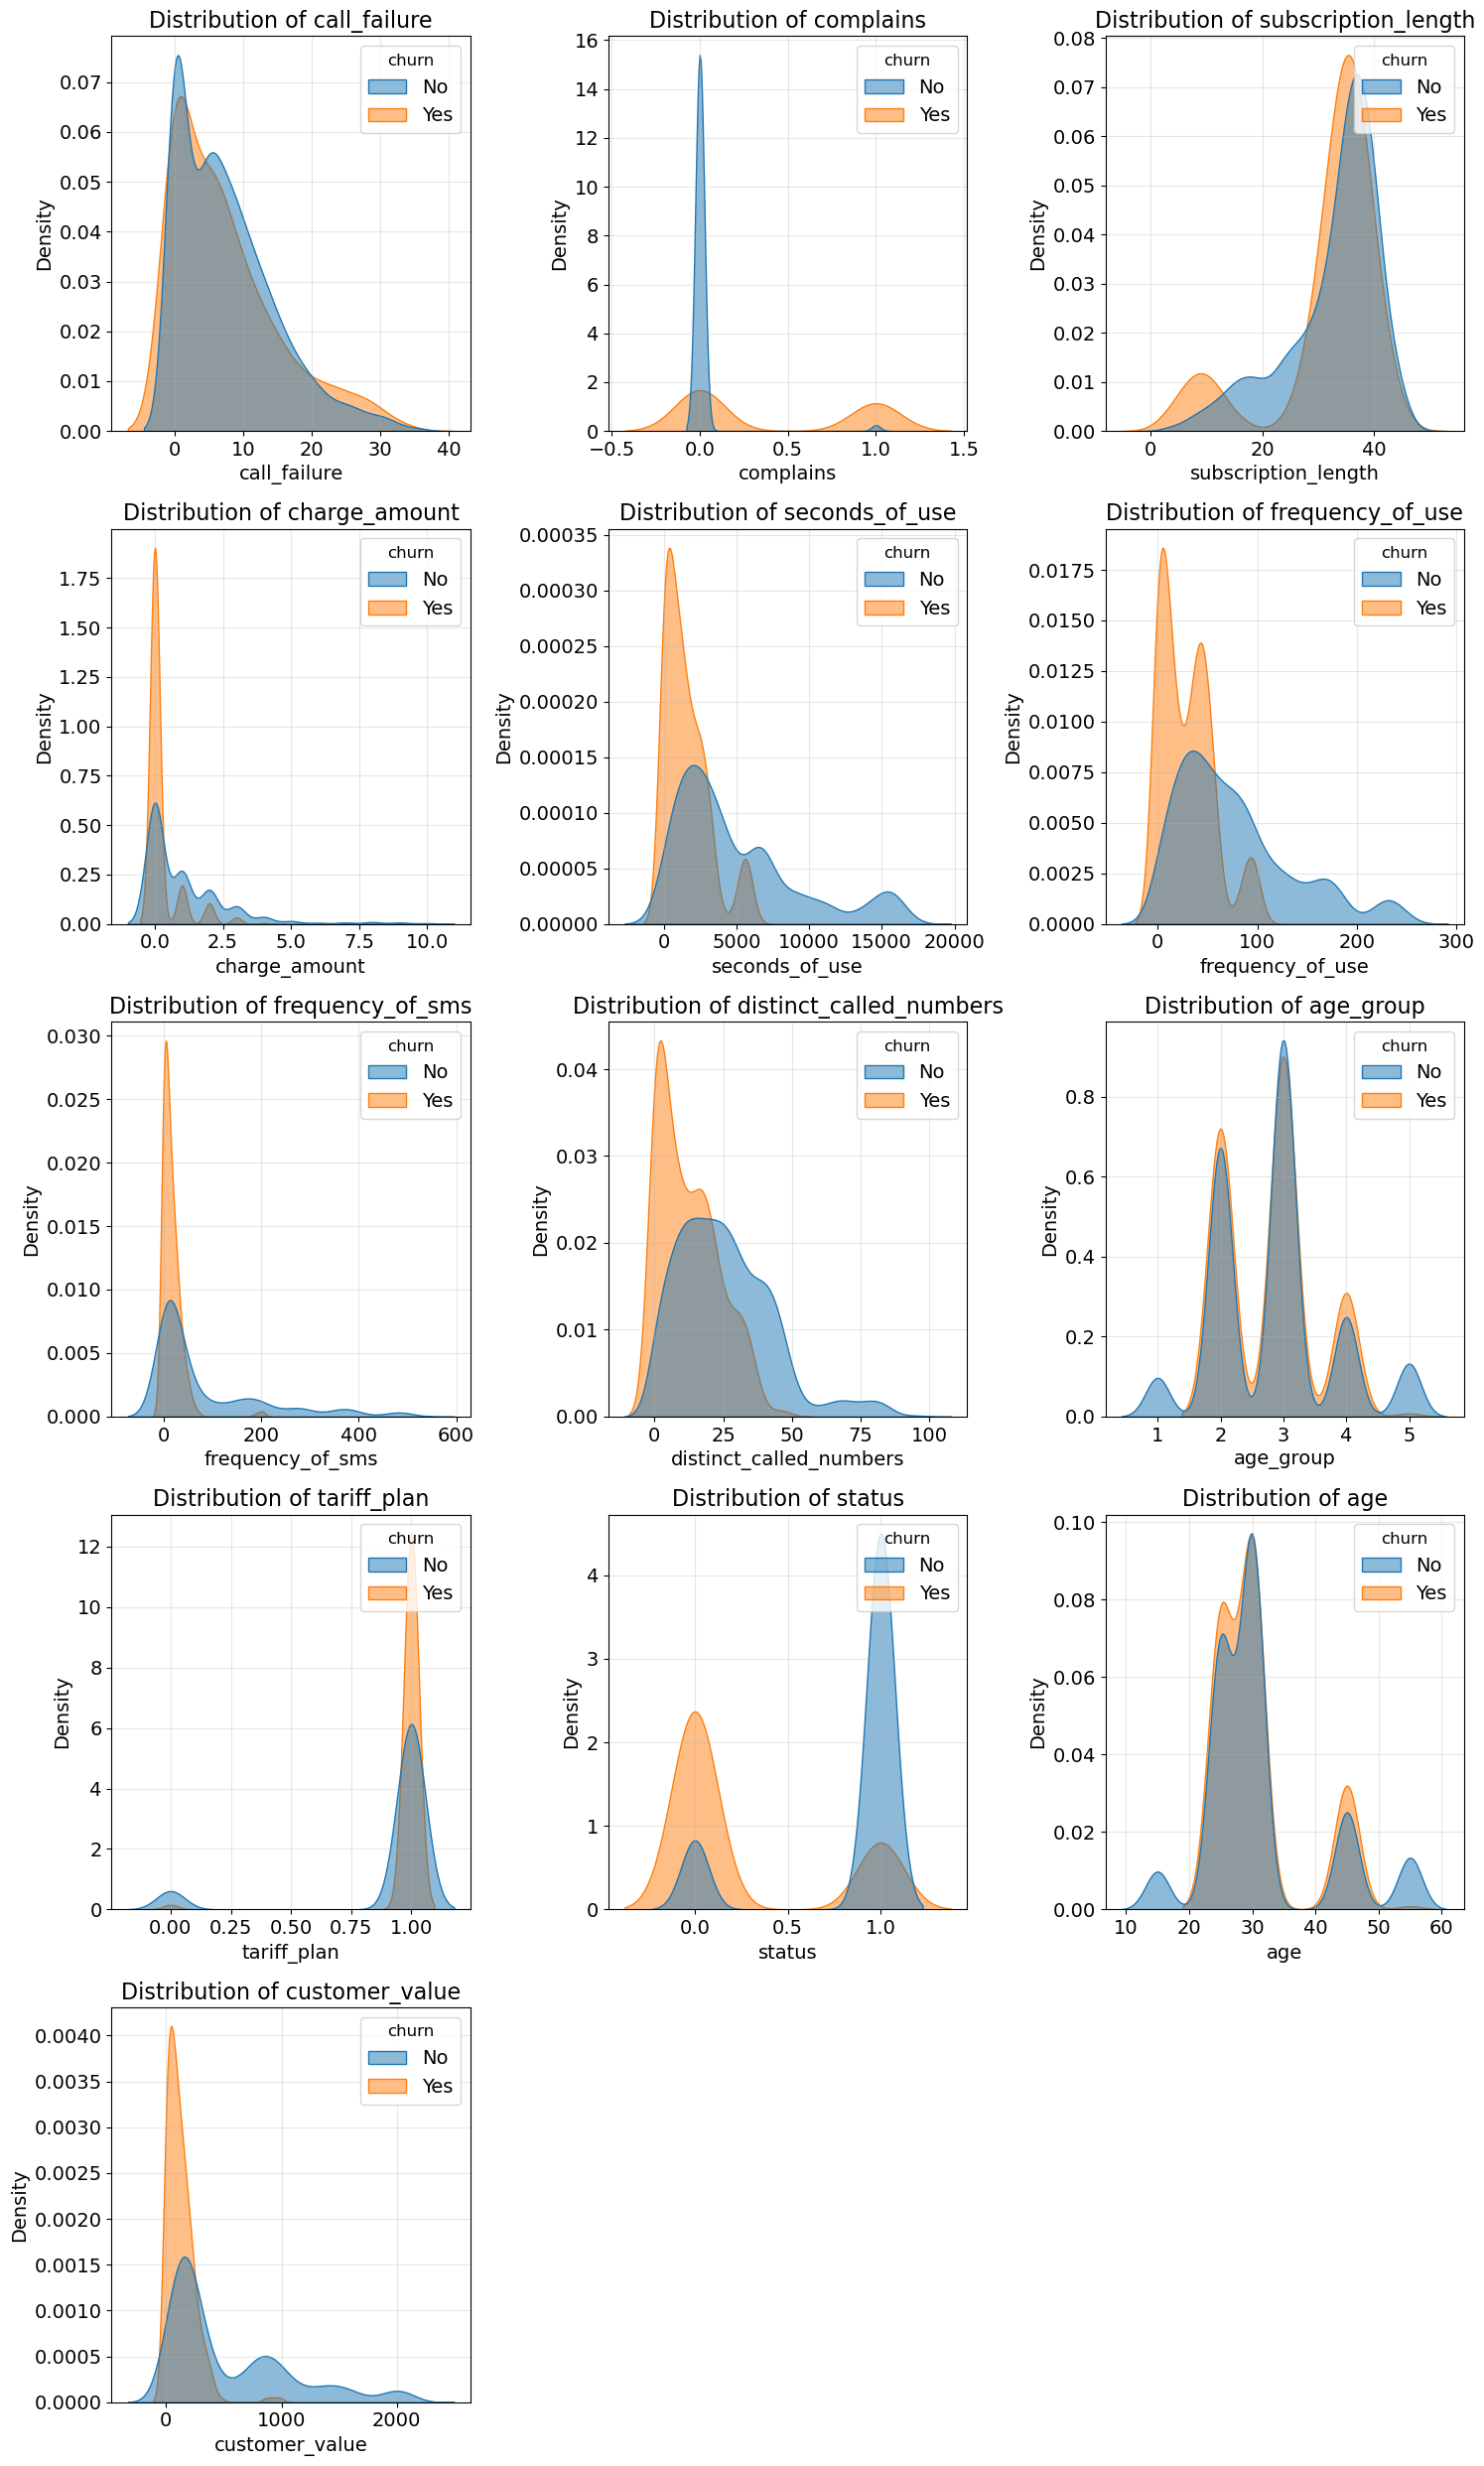

In [183]:
def plot_distributions(df):
    """
    Create density plots for all numeric columns, split by churn status.
    """
    # Get numeric columns except 'churn'
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols.remove('churn') if 'churn' in numeric_cols else None
    
    # Calculate grid dimensions
    n_cols = 3  # We can adjust this for different layouts
    n_rows = int(np.ceil(len(numeric_cols) / n_cols))
    
    # Set global font size for plots
    plt.rc('axes', titlesize=16)  # Title font size
    plt.rc('axes', labelsize=14)  # Axis labels font size
    plt.rc('xtick', labelsize=14)  # X-tick labels font size
    plt.rc('ytick', labelsize=14)  # Y-tick labels font size
    plt.rc('legend', fontsize=14)  # Legend font size
    plt.rc('font', size=12)  # General font size
    
    # Create figure with subplots
    fig = plt.figure(figsize=(15, 5*n_rows))
    gs = GridSpec(n_rows, n_cols)
    
    # Create a plot for each numeric column
    for idx, column in enumerate(numeric_cols):
        row = idx // n_cols
        col = idx % n_cols
        
        ax = fig.add_subplot(gs[row, col])
        
        # Create density plot
        sns.kdeplot(data=df, x=column, hue='churn',
                   fill=True, common_norm=False,
                   alpha=.5, linewidth=1,
                   ax=ax)
        
        # Customize plot
        ax.set_title(f'Distribution of {column}')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save the figure before showing it
    plt.savefig('distributions.png', dpi=300, bbox_inches='tight')
    plt.show()

def main():
    # Load the data
    df = pd.read_csv('Customer Churn.csv')
    df.columns = df.columns.str.lower().str.replace(r'\s+', '_', regex=True)
    df[['tariff_plan', 'status']] = df[['tariff_plan', 'status']].replace(2, 0)
    
    # Convert churn to categorical Yes/No
    df['churn'] = df['churn'].map({0: 'No', 1: 'Yes'})
    
    # Create plots
    plot_distributions(df)

if __name__ == "__main__":
    main()


In [41]:
class ChurnModel:
    def __init__(self, random_state: int = 7):
        self.random_state = random_state
        self.model = None
        self.best_params = None
        
    def prepare_data(self, df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
        df.columns = df.columns.str.lower().str.replace(r'\s+', '_', regex=True)
        
        if 'churn' not in df.columns:
            raise ValueError("'churn' column not found in dataset")
        
        df['churn'] = pd.to_numeric(df['churn'], errors='coerce')
        df = df.dropna()
        
        X = pd.get_dummies(df.drop('churn', axis=1), drop_first=True)
        y = df['churn']
        
        return train_test_split(
            X, y, test_size=0.1, random_state=self.random_state, stratify=y
        )
    
    @staticmethod
    def calculate_metrics(y_true: np.ndarray, y_pred: np.ndarray, y_pred_proba: np.ndarray) -> Dict[str, float]:
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        n_samples = len(y_true)
    
        return {
            'accuracy': (tp + tn) / n_samples,
            'precision': tp / (tp + fp) if (tp + fp) > 0 else 0,
            'f1': 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0,
            'auc': roc_auc_score(y_true, y_pred_proba),
            'tn_rate': tn / (tn + fp) if (tn + fp) > 0 else 0,
            'fp_rate': fp / (tn + fp) if (tn + fp) > 0 else 0,
            'fn_rate': fn / (tp + fn) if (tp + fn) > 0 else 0,
            'tp_rate': tp / (tp + fn) if (tp + fn) > 0 else 0
        }
        
    def plot_results(self, metrics: Dict[str, float], y_test: np.ndarray, y_pred: np.ndarray, 
                y_pred_proba: np.ndarray) -> None:
        # Plot Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        labels = np.array([["True Negative", "False Positive"],
                           ["False Negative", "True Positive"]])
        
        plt.figure(figsize=(10, 8))
        colors = ["#fff5f0", "#FF9B62"]
        custom_cmap = LinearSegmentedColormap.from_list("custom", colors)
        ax = sns.heatmap(cm, annot=True, fmt='d', cmap=custom_cmap,
                         xticklabels=['No Churn', 'Churn'], 
                         yticklabels=['No Churn', 'Churn'],
                         annot_kws={"fontsize": 22})
        
        # Add the labels at the top of each box
        for i in range(2):
            for j in range(2):
                ax.text(j + 0.5, i + 0.05, labels[i, j], 
                        color='black', ha='center', va='center', fontsize=16)
        
        plt.xlabel('Predicted Churn', fontsize=16, weight='bold')
        plt.ylabel('True Churn', fontsize=16, weight='bold')
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.tight_layout()
        plt.savefig("confusion_matrix.png", dpi=300)
        plt.close()

        # Plot ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='#FF9B62', label='ROC curve (AUC = 0.9955)', linewidth=2)
        plt.plot([0, 1], [0, 1], 'k--', label='Random chance', linewidth=1.5)
        plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
        plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12)
        plt.grid(visible=True, linestyle='--', linewidth=0.5)
        plt.legend(loc='lower right', fontsize=10)
        plt.savefig("roc_auc_curve.png", dpi=300)
        plt.close()
    
        # Feature Importance Plot
        importance_scores = self.model.feature_importances_
        feature_names = self.model.feature_names_in_
        
        # Sort features by importance
        indices = np.argsort(importance_scores)[::-1]
        
        # Plot top 15 features
        plt.figure(figsize=(10, 6))
        plt.barh(range(min(15, len(feature_names)))[::-1],
                importance_scores[indices][:15],
                color="#FF9B62")
        
        plt.yticks(range(min(15, len(feature_names)))[::-1], 
                  [feature_names[i] for i in indices][:15], fontsize=12)
        plt.xticks(fontsize=12)
        plt.xlabel('Feature Importance', fontsize=12)
        plt.tight_layout()
        plt.savefig(f"feature_importance.png", dpi=300)
        plt.close()


    def tune_model(self, X_train: pd.DataFrame, y_train: pd.Series, 
                  param_grid: Optional[Dict[str, list]] = None) -> None:
        if param_grid is None:
            param_grid = {
                'max_depth': [3, 5, 7, 10, 15, 20, 25],
                'learning_rate': [0.01, 0.1],
                'subsample': [0.8, 0.9],
                'colsample_bytree': [0.8, 0.9],
                'min_child_weight': [1, 3, 5, 10],
                'scale_pos_weight': [(y_train == 0).sum() / (y_train == 1).sum()]
            }
        
        kf = KFold(n_splits=5, shuffle=True, random_state=self.random_state)
        
        best_score = -np.inf
        total_combinations = np.prod([len(v) for v in param_grid.values()])
        print(f"\nTesting {total_combinations} parameter combinations...")
        
        for params in self._param_combinations(param_grid):
            scores = []
            for train_idx, val_idx in kf.split(X_train):
                X_train_cv = X_train.iloc[train_idx]
                X_val_cv = X_train.iloc[val_idx]
                y_train_cv = y_train.iloc[train_idx]
                y_val_cv = y_train.iloc[val_idx]
                
                model = xgb.XGBClassifier(
                    objective='binary:logistic',
                    random_state=self.random_state,
                    eval_metric='auc',
                    **params
                )
                
                model.fit(X_train_cv, y_train_cv)
                y_pred_proba = model.predict_proba(X_val_cv)[:, 1]
                scores.append(roc_auc_score(y_val_cv, y_pred_proba))
            
            mean_score = np.mean(scores)
            if mean_score > best_score:
                best_score = mean_score
                self.best_params = params
        
        print(f"Best CV score: {best_score:.4f}")
        print(f"Best parameters: {self.best_params}")
    
    @staticmethod
    def _param_combinations(param_grid: Dict[str, list]):
        keys = list(param_grid.keys())
        values = list(param_grid.values())
        for combination in product(*values):
            yield dict(zip(keys, combination))
    
    def fit(self, X_train: pd.DataFrame, y_train: pd.Series) -> None:
        if self.best_params is None:
            raise ValueError("Must run tune_model before fitting")
            
        self.model = xgb.XGBClassifier(
            objective='binary:logistic',
            random_state=self.random_state,
            eval_metric='auc',
            **self.best_params
        )
        self.model.fit(X_train, y_train)
    
    def predict(self, X: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray]:
        if self.model is None:
            raise ValueError("Model not fitted")
        return self.model.predict(X), self.model.predict_proba(X)[:, 1]

def main(df_path: str) -> None:
    try:
        print("Loading data...")
        df = pd.read_csv(df_path)
        model = ChurnModel()
        
        print("Preparing data...")
        X_train, X_test, y_train, y_test = model.prepare_data(df)
        
        print("\nTuning model parameters...")
        model.tune_model(X_train, y_train)
        
        print("\nTraining final model...")
        model.fit(X_train, y_train)
        
        print("\nGenerating predictions and metrics...")
        y_pred, y_pred_proba = model.predict(X_test)
        metrics = model.calculate_metrics(y_test, y_pred, y_pred_proba)
        model.plot_results(metrics, y_test, y_pred, y_pred_proba)
        
        print("\nModel Performance Metrics:")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")
            
    except Exception as e:
        print(f"Error in execution: {str(e)}")
        raise

if __name__ == "__main__":
    main("Customer Churn.csv")

Loading data...
Preparing data...

Tuning model parameters...

Testing 224 parameter combinations...
Best CV score: 0.9879
Best parameters: {'max_depth': 15, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8, 'min_child_weight': 1, 'scale_pos_weight': 5.370786516853933}

Training final model...

Generating predictions and metrics...

Model Performance Metrics:
accuracy: 0.9778
precision: 0.9057
f1: 0.9320
auc: 0.9955
tn_rate: 0.9811
fp_rate: 0.0189
fn_rate: 0.0400
tp_rate: 0.9600
